# This notebook serves as proof-of-concept for algorithm implementation for SQSP

In [1]:
# imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, BasicAer
import numpy as np

## helper functions

In [7]:
def g_gate(qc, alpha, control, target):
    qc.rz(alpha, target)
    qc.ry(2*1/np.cos(alpha), target)
    if len(control) > 0:
        qc.mcx(control, target)
    else: 
        qc.x(target)
    qc.ry(-2*1/np.cos(alpha), target)
    qc.rz(-alpha, target)

## implementation algorithm 1

In [16]:
def algorithm1(s, coefficients, num_qubits):
    C = QuantumCircuit(num_qubits, num_qubits)
    dif_qubits = [] # stack of bits
    dif_values = [] # stack of boolean values
    t = s
    t0 = []
    t1 = []
    t0_t1_diff = -1
    while len(t) > 1:
        # TODO: t0 and t1 should be as unequal as possible -> DONE
        b_max = 0
        for b in range(num_qubits):
            t0_tmp = []
            t1_tmp = []
            t_diff_tmp = 0
            for elem in t:
                if elem[b] == "0":
                    t0_tmp.append(elem)
                else:
                    t1_tmp.append(elem)
                    
            t_diff_tmp = abs(len(t0_tmp)-len(t1_tmp))
            if t0_t1_diff < t_diff_tmp and len(t0_tmp) > 0 and len(t1_tmp) > 0:
                t0 = t0_tmp
                t1 = t1_tmp
                t0_t1_diff = t_diff_tmp
                b_max = b
        dif_qubits.append(b_max)
        if len(t0) < len(t1):
            t = t0
            dif_values.append(0)
        else:
            t = t1
            dif_values.append(1)
    print(t)
    print(dif_values)
    print(dif_qubits)
    
    dif = dif_qubits.pop()
    dif_values.pop()
    x1 = t[0]
    # create T'
    t_ = []
    for elem in s:
        found = 1
        for i in range(len(dif_qubits)):
            if elem[i] != dif_values[i]:
                found = 0
                break
        if found == 1:
            t_.append(elem)
    print("before remove of x1:", t_)
    # remove x1 from T'
    t_.remove(x1)
    print("after remove of x1:", t_)
    
    t0_ = []
    t1_ = []
    t0_t1_diff_ = -1
    while len(t_) > 1:
        b_max = 0
        for b in range(num_qubits):
            t0_tmp = []
            t1_tmp = []
            t_diff_tmp = 0
            for elem in t_:
                # print(elem)
                if elem[b] == "0":
                    t0_tmp.append(elem)
                else:
                    t1_tmp.append(elem)
                t_diff_tmp = abs(len(t0_tmp)-len(t1_tmp))
            
            print(t0_tmp, " ", t1_tmp, " ", t0_t1_diff_, " ", t_diff_tmp)
            
            if t0_t1_diff_ < t_diff_tmp and len(t0_tmp) > 0 and len(t1_tmp) > 0:
                t0_ = t0_tmp
                t1_ = t1_tmp
                t0_t1_diff_ = t_diff_tmp
                b_max = b
        dif_qubits.append(b_max)
        print("lengths: ", len(t0_), " ", len(t1_))
        if len(t0_) < len(t1_):
            t_ = t0_
            dif_values.append(0)
            print("0 ", t_)
        else:
            t_ = t1_
            dif_values.append(1)
            print("1 ", t_)
    x2 = t_[0]
    
    print(t_)
    print(dif_values)
    print(dif_qubits)
    
    if x1[dif] != 1:
        print("applying NOT on: ", dif)
        C.x(dif)
    for b in range(num_qubits):
        if b != dif:
            if x1[b] != x2[b]:
                print("applying CNOT on: ", dif, " ", b)
                C.cx(dif, b)
    for b in dif_qubits:
        if x2[b] != 1:
            print("applying NOT on: ", b)
            C.x(b)
        
    # calculate alpha
    # get c_x1
    idx_x1 = s.index(x1)
    c_x1 = coefficients[idx_x1]
    # get c_x2
    idx_x2 = s.index(x2)
    c_x2 = coefficients[idx_x2]
    # normalize
    c_x1_ = np.sqrt(c_x1**2/(c_x1**2 + c_x2**2))
    c_x2_ = np.sqrt(c_x2**2/(c_x1**2 + c_x2**2))
    print("applying G: ", dif_qubits, " ", dif, " ", c_x1_, " ", c_x2_)
    g_gate(C, c_x1_, dif_qubits, dif)
    s_= s
    s_.remove(x2)
    return C, s_
        

In [17]:
# test algorithm1
algorithm1(["001","100","111"], [1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)], 3)

['001']
[0]
[0]
before remove of x1: ['001', '100', '111']
after remove of x1: ['100', '111']
[]   ['100', '111']   -1   2
['100']   ['111']   -1   0
['100']   ['111']   0   0
lengths:  1   1
1  ['111']
['111']
[1]
[1]
applying NOT on:  0
applying CNOT on:  0   1
applying NOT on:  1
applying G:  [1]   0   0.7071067811865476   0.7071067811865476


(<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fec69e6f820>,
 ['001', '100'])

## implementation algorithm 2

In [18]:
def algorithm2(s, coefficients, num_qubits):
    #first sanity check
    if num_qubits == 0 or len(s) > num_qubits or len(coefficients) != len(s):
        print("Error: params wrong")
        return
    # check if coefficients fit:
    check_sum = 0.0
    for coeff in coefficients:
        check_sum += coeff**2
    if np.isclose(check_sum, 1.0, rtol=1e-05, atol=1e-08, equal_nan=False) == False:
        print("Error: Coefficients do not sum up to 1.0: ", check_sum)
        return
    C = QuantumCircuit(num_qubits, num_qubits)
    #phi = ""
    while len(s) > 1:
        C_hat, s_ = algorithm1(s, coefficients, num_qubits)
        C = C.compose(C_hat)
        s = s_
    
    # add not gates
    for i in range(len(s[0])):
        if s[0][i] == 1:
            C.x(i)
    #invert
    C = C.inverse()
    
    return C

['001']
[0]
[0]
before remove of x1: ['001', '100', '111']
after remove of x1: ['100', '111']
[]   ['100', '111']   -1   2
['100']   ['111']   -1   0
['100']   ['111']   0   0
lengths:  1   1
1  ['111']
['111']
[1]
[1]
applying NOT on:  0
applying CNOT on:  0   1
applying NOT on:  1
applying G:  [1]   0   0.7071067811865476   0.7071067811865476
['100']
[1]
[0]
before remove of x1: ['001', '100']
after remove of x1: ['001']
['001']
[]
[]
applying NOT on:  0
applying CNOT on:  0   2
applying G:  []   0   0.7071067811865476   0.7071067811865476


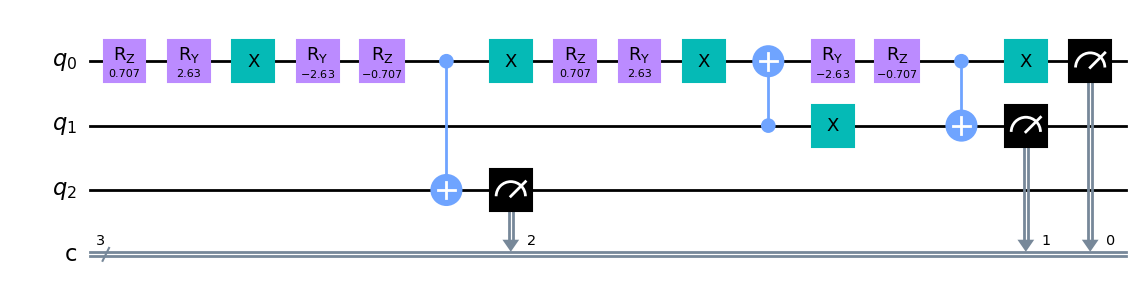

In [19]:
# test algorithm2
C = algorithm2(["001","100","111"], [1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)], 3)

C.measure([0,1,2], [0,1,2])
C.draw('mpl')

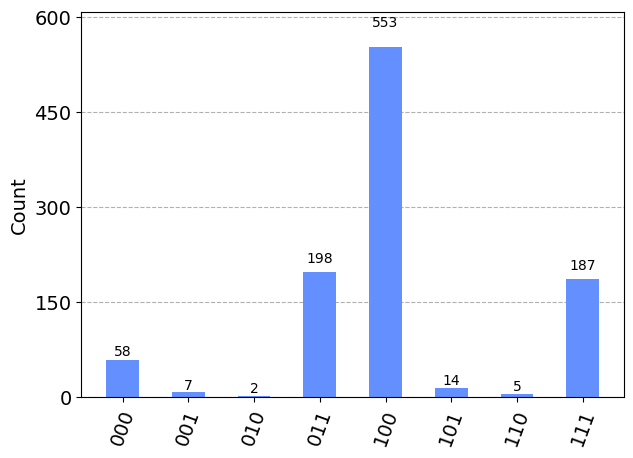

In [20]:
# use fake santiago backend
from qiskit.providers.fake_provider import FakeSantiagoV2
santiago = FakeSantiagoV2()
santiago.operations

from qiskit.visualization import plot_histogram

job = execute(C, santiago, shots=1024) #we specify our job, which circuit to execute and how many times
result = job.result() #we extract the results from the job
counts = result.get_counts() #this time, we are not getting the state, but the counts!
plot_histogram(counts) #a new plotting method! this works for counts obviously!

## example 1: GHZ

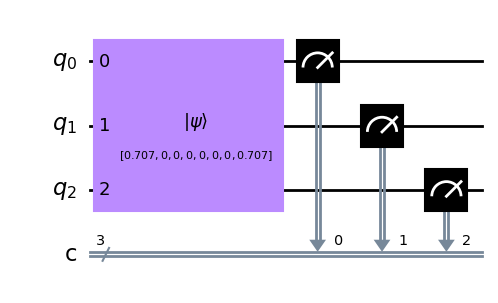

In [7]:
desired_vector = [
    1/np.sqrt(2) * complex(1,0),
    0,
    0,
    0,
    0,
    0,
    0,
    1/np.sqrt(2) * complex(1,0)
]

qc_ghz = QuantumCircuit(3,3)
qc_ghz.initialize(desired_vector, [0,1,2])
qc_ghz.measure([0,1,2], [0,1,2])
qc_ghz.draw('mpl')

In [8]:
# use fake santiago backend
from qiskit.providers.fake_provider import FakeSantiagoV2
santiago = FakeSantiagoV2()
santiago.operations

[Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
 Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='x', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
 Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 Delay(duration=t[unit=dt])]

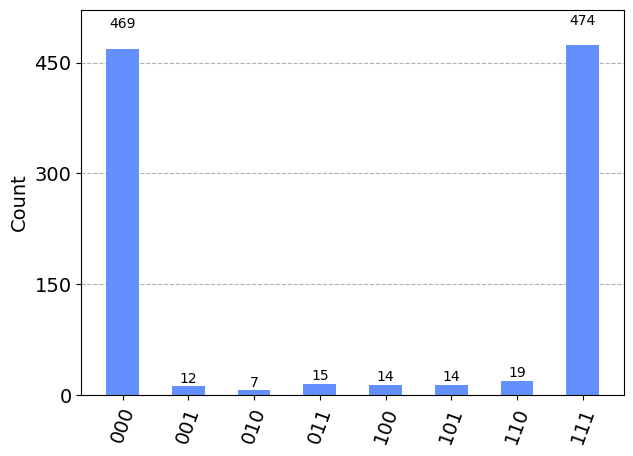

In [9]:
from qiskit.visualization import plot_histogram

job = execute(qc_ghz, santiago, shots=1024) #we specify our job, which circuit to execute and how many times
result = job.result() #we extract the results from the job
counts = result.get_counts() #this time, we are not getting the state, but the counts!
plot_histogram(counts) #a new plotting method! this works for counts obviously!

## example 2: W-State

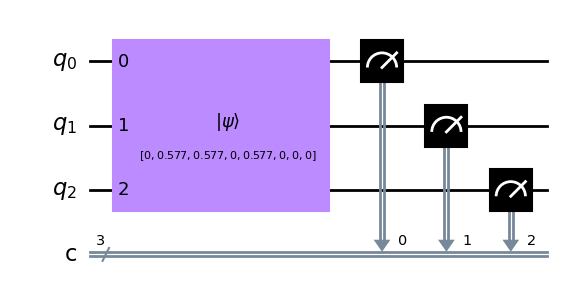

In [13]:
desired_vector = [
    0,
    1/np.sqrt(3) * complex(1,0),
    1/np.sqrt(3) * complex(1,0),
    0,
    1/np.sqrt(3) * complex(1,0),
    0,
    0,
    0
]

qc_w = QuantumCircuit(3,3)
qc_w.initialize(desired_vector, [0,1,2])
qc_w.measure([0,1,2], [0,1,2])
qc_w.draw('mpl')

In [14]:
# use fake santiago backend
from qiskit.providers.fake_provider import FakeSantiagoV2
santiago = FakeSantiagoV2()
santiago.operations

[Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
 Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='x', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
 Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 Delay(duration=t[unit=dt])]

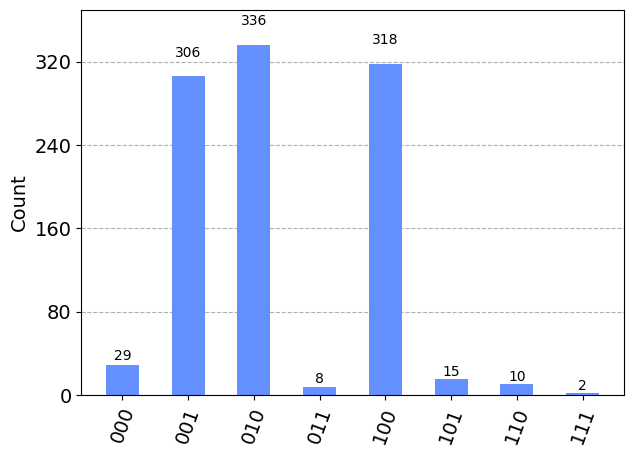

In [15]:
from qiskit.visualization import plot_histogram

job = execute(qc_w, santiago, shots=1024) #we specify our job, which circuit to execute and how many times
result = job.result() #we extract the results from the job
counts = result.get_counts() #this time, we are not getting the state, but the counts!
plot_histogram(counts) #a new plotting method! this works for counts obviously!